<a href="https://colab.research.google.com/github/DiegoFortezaBenito/APRENDIZAJE_AUTOMATICO_23_24/blob/main/Pr%C3%A1ctica4_Gr10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Práctica 4. Algoritmo genético

## Instalación de paquetes

In [1]:
!pip install deap
!pip install matplotlib
!pip install scoop
!pip install numpy
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scoop: filename=scoop-0.7.2.0-py3-none-any.whl size=78113 sha256=7cc5a994da0fcbf5eef659f1fbfad2b2be61a381c26af4f79d90cc3defbd9dbe
  Stored in directory: /root/.cache/pip/wheels/26/c6/da/088e4bffcfbc33fa40644ca636267bc801c8fd9eef973483db
Successfully built scoop


## Importación de librerías

In [2]:
import random
import math
import numpy as np
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

##Problema 1

**Enunciado**

Encontrar los máximos de la función "picos":

$$z = f(x,y) = 3(1-x)^2e^{-(x^2)-(y+1)^2}-10(x/5-x^3-y^5)e^{-x^2-y^2}-1/3e^{-(x+1)^2-y^2}$$

En el dominio $$\{x,y\} \in [-100,100]$$

####Espacio de búsqueda o domino de la solución. Gráfica de la función objetivo

Text(0.5, 0, 'f(x,y)')

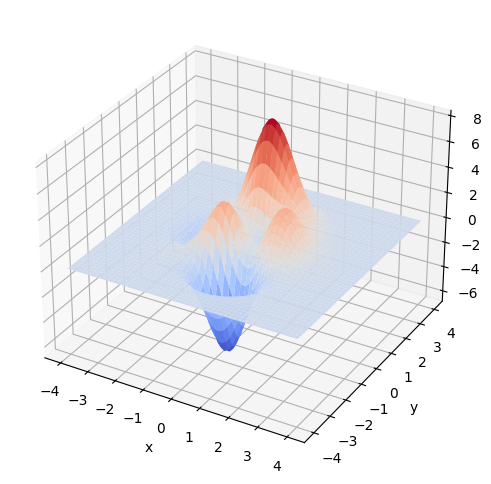

In [3]:
# Definimos la función objetivo
def funcion_prueba(x):
    # x es x[0] e y es x[1]
    res = 3*(1-x[0])**2 * np.exp(-(x[0]**2)-(x[1]+1)**2) - 10*(x[0]/5 - x[0]**3 - x[1]**5) * np.exp(-x[0]**2-x[1]**2) - 1/3*np.exp(-(x[0]+1)**2-x[1]**2)
    return res

# Generamos vectores que barran todo el dominio
x = np.linspace(-4, 4, 1000)
y = np.linspace(-4, 4, 1000)

# Evaluamos todos los valores de las variables
x_ax, y_ax = np.meshgrid(x, y)
vals = np.c_[x_ax.ravel(), y_ax.ravel()]
fx = np.reshape([funcion_prueba(val) for val in vals],(1000, 1000))

# Representamos los resultados obtenidos
figure_3d = plt.figure(figsize=(8,6))
ax = figure_3d.add_subplot(projection = '3d')
ax.plot_surface(x_ax, y_ax, fx, cmap=cm.coolwarm)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x,y)")

Tras buscar el par "x, y" (x[0] y x[1]) de la función, encontramos que el máximo está entre 8.0926 y 8.0980, donde x e y se encuentran alrededor de x = -0.0303 e y = 1.6061.

Esto lo hacemos para poder observar como de cerca se quedan cada uno de los "Experimentos" al máximo real de la función picos y poder así compararlos.

#### 0. Hiperparámetros

En esta sección se definen los hiperparámetros del modelo que se modificarán en busca de la mejor solución

In [4]:
N_POBLACION = 32 # Tamaño población
CXPB = 0.5 # Probabilidad de Cruce
MUTPB = 0.2 # Probabilidad de Mutación
NGEN = 20 # Número de Generaciones
UNIFORM_INDPB = 0.5 # Probabilidad de cruce Uniforme

#### 1. Definición de los objetos de la librería Deap

In [5]:
import random
from deap import base
from deap import creator
from deap import tools

Definimos las clases `FitnessMax` e `Individual`


Definimos una _estructura_ o _método_ llamado `FitnessMax`. Esta hereda de base `base.Fitness` y tiene un atributo `weights` que define el tipo de problema de optimización. Como en este caso es de maximizar `weights=(1.0,)` (el uno positivo).

También creamos como va a ser nuestro individuo. A este _método_ le llamamos `Individual`, el cual hereda una lista, que será un par de genes como hemos dicho anteriormente, y contiene el atributo de fitness (su calidad), inicializado con el objeto `FitnessMax` (creado anteriormente).

In [6]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

In [7]:
creator.create("Individual", list, fitness=creator.FitnessMax)

Creamos los 2 experimentos:
 - Cruce en un punto
 - Cruce en dos puntos
 - Cruce Uniforme

 Nota: El cruce uniforme no lo pide el enunciado pero se propone como objeto de estudio con la misma función.

El cruce uniforme es como lanzar una moneda al aire por cada _cromosoma_ para ver cual de los dos padres se coge. Es por eso que tenemos un nuevo atributo `UNIFORM_INDPB` el cual representa la probabilidad de intercambiar los genes. Nosotros, siguiendo la analogía de la moneda, hemos escogido una probabilidad de 0.5.


In [8]:
toolbox1 = base.Toolbox()
toolbox2 = base.Toolbox()
toolbox3 = base.Toolbox()

EXPERIMENTOS = [toolbox1, toolbox2, toolbox3]

Definimos nuestra *caja de herramientas* donde almacenaremos las funciones necesarias para el algoritmo. Estas son:
* Attr_Uniform: genera un valor aleatorio entre -100 y 100 haciendo uso de la libreria `random` y su método _uniform_ (distribución uniformw)
* Individual: función para **crear los individuos** de forma **aleatoria**. Esta llama a `tools.InitRepeat` la cual almacenará en un container de estructura `creator.Individual` (creada anteriormente con _creator_ ) llamando a la función `toolbox.attr_uniform` dos veces (generamos dos genes aleatorios x e y por individuo).
* Population: función para **crear la población**. Es análoga a la anterior. Lo único que esta almacena en una lista llamando a `toolbos.Individual` 32 veces. Es decir, genera 32 individuos.


In [9]:
for toolbox in EXPERIMENTOS:
  # Generación de genes
  toolbox.register("attr_uniform", random.uniform, -100, 100)
  # Generación de inviduos
  toolbox.register("individual", tools.initRepeat, creator.Individual,
                   toolbox.attr_uniform, 2)
  # Generación de población
  toolbox.register("population", tools.initRepeat, list,
                   toolbox.individual, N_POBLACION)

Comenzamos añadiendo a la toolbox los genes de manera aleatoria; a continuación, los individuos juntando pares de genes y por último, la población, tomando 32 individuos.

Comprobamos que las funciones funcionan correctamente

In [10]:
# Ejemplo de la generación de un individuo aleatorio
individuo = toolbox1.individual()
print(individuo)

# Ejemplo de creación de una población. Se ve que es una lista de 32 listas (una por cada individuo)
poblacion = toolbox1.population()
print(poblacion)
print(len(poblacion))

# Vacío, porque aun no ha sido evaluado
individuo.fitness.values

[-2.7754026546920016, -16.79964777053607]
[[-75.5513256190892, -0.270154170475692], [17.311040602751575, -19.32443299037807], [6.27976558314316, 27.46538584179541], [-65.80627353743836, -6.007250064403834], [-18.584701025283337, -5.629438194253851], [-51.87262743764869, -65.67998820157352], [-3.5330680449597622, 67.27219864552791], [60.460050289864256, -56.22530077475276], [60.467687747940545, -43.65021793547066], [-47.31425717267261, -70.04980661036473], [55.858897118514165, 47.127856656992776], [17.427661657628263, 70.93741791313036], [20.08991282832872, -37.73292144345379], [-86.81442110788223, 6.634918054813795], [-22.998986268210842, 53.69978826184493], [-49.7830035934788, 20.476227569970547], [3.1357286854163675, -34.2102067399281], [53.86723770419056, -88.1638938004482], [-33.12042651696605, -59.54361773659518], [-38.00105620823151, -77.2552563760078], [-37.66019242830787, 20.872496419209057], [-9.517884644111291, 82.97560065292583], [-87.11538075147173, 52.33879475890032], [89.

()

#### 2. Función objetivo y operadores genéticos

In [11]:
def funcion_objetivo(x):
    """
    Función objetivo de nuestro problema
    """
    for i in range(len(x)):
        if x[i] > 100 or x[i] < -100:
            return -1,
    res = 3*(1-x[0])**2 * np.exp(-(x[0]**2)-(x[1]+1)**2) - 10*(x[0]/5 - x[0]**3 - x[1]**5) * np.exp(-x[0]**2-x[1]**2) - 1/3*np.exp(-(x[0]+1)**2-x[1]**2)
    return res,

In [12]:
for toolbox in EXPERIMENTOS:
  toolbox.register("evaluate", funcion_objetivo)

#### 3. Incorporar los operadores genéticos

CRUCE

In [13]:
# Registro de operacion genética de cruce
toolbox1.register("mate", tools.cxOnePoint)
toolbox2.register("mate", tools.cxTwoPoint)
toolbox3.register("mate", tools.cxUniform, indpb = UNIFORM_INDPB)

MUTACIÓN

In [14]:
for toolbox in EXPERIMENTOS:
  toolbox.register("mutate", tools.mutGaussian, mu=0,
                   sigma= 5, indpb=0.1)

SELECCIÓN

In [15]:
for toolbox in EXPERIMENTOS:
  toolbox.register("select", tools.selTournament, tournsize=3)

#### 4. Últimos pasos: Algoritmo genético como una caja negra

Es necesario definir una semilla a la hora de generar los números aleatorios, de esta forma, se toman números aleatorios pero que si volvemos a ejecutar el código, serán los mismos (parcialmente aleatorio).

In [16]:
random.seed(42)

In [17]:
#Generamos la Población Inicial
pop1 = toolbox1.population()
pop2 = toolbox2.population()
pop3 = toolbox3.population()
INITIAL_POP = [pop1, pop2, pop3]

In [18]:
# Definimos el objeto hof que almacenará el mejor individuo de cada experimento
# encontrado a lo largo de las generaciones.
hof1 = tools.HallOfFame(1)
hof2 = tools.HallOfFame(1)
hof3 = tools.HallOfFame(1)
HOF = [hof1, hof2, hof3]

In [19]:
# Definimos un objeto para guardar las estadísticas de la
# población a lo largo de las generaciones.
stats1 = tools.Statistics(lambda ind: ind.fitness.values)
stats2 = tools.Statistics(lambda ind: ind.fitness.values)
stats3 = tools.Statistics(lambda ind: ind.fitness.values)
STATS = [stats1, stats2, stats3]

In [20]:
# En dicho objeto, guardaremos: la media, la desviación típica, el mínimo
# y el máximo por genereación.
for stats in STATS:
  stats.register("avg", np.mean)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("max", np.max)

In [21]:
# loogbook contendrá todo el registro de evolución
logbook1 = tools.Logbook()
logbook2 = tools.Logbook()
logbook3 = tools.Logbook()
LOGBOOKS = [logbook1, logbook2, logbook3]

#### 5. Lanzamos los experimentos

In [22]:
# Empaquetamos los experimentos en una lista para lanzarlos cómodamente a través de un bucle for
E = list(zip(EXPERIMENTOS, INITIAL_POP, HOF, STATS, LOGBOOKS))

In [23]:
i = 0
for exp, pop, hof, stats, logbook in E:
  i += 1
  print(f'\nEXPERIMENTO {i}:\n')
  pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB,
                                       mutpb=MUTPB, ngen=NGEN, stats=stats,
                                       halloffame=hof, verbose=True)


EXPERIMENTO 1:

gen	nevals	avg          	std	min          	max
0  	32    	-2.16768e-285	0  	-6.93659e-284	0  
1  	19    	0            	0  	0            	0  
2  	17    	0            	0  	0            	0  
3  	21    	5.02362e-122 	2.79703e-121	0            	1.60756e-120
4  	18    	1.00472e-121 	3.89128e-121	0            	1.60756e-120
5  	18    	2.39659e-54  	1.33437e-53 	-2.11661e-232	7.66909e-53 
6  	26    	5.98937e-22  	3.33474e-21 	0            	1.9166e-20  
7  	24    	1.19787e-21  	4.63935e-21 	0            	1.9166e-20  
8  	15    	2.99469e-21  	6.95902e-21 	0            	1.9166e-20  
9  	17    	8.38512e-21  	9.50784e-21 	3.29447e-153 	1.9166e-20  
10 	22    	1.6752e-20   	1.13476e-20 	0            	5.52394e-20 
11 	19    	2.6984e-20   	1.3945e-20  	1.07487e-25  	5.52394e-20 
12 	17    	3.27612e-20  	1.4561e-20  	8.51459e-21  	5.52394e-20 
13 	16    	4.51936e-20  	1.10717e-20 	1.9166e-20   	5.52394e-20 
14 	21    	4.94157e-20  	1.38597e-20 	2.81985e-25  	5.52394e-20 
15 	21    	5.30

##Conclusiones
Tras lanzar los experimentos, vemos que en solo 20 generaciones y con una población de 32 individuos, los resultados son poco favorables.

El Experimento 3, haciendo uso de un cruce "Uniforme" devuelve un máximo lógico en comparación con los dos primeros desde la generación 18. Sin embargo, los experimientos 1 y 2 que hacen uso del cruce "punto de cruce" (de uno y dos puntos respectivamente) finalizan la veinteaba generación sin aproximarse al máximo real.

¿Quiere decir esto que el cruce uniforme es el mejor?

Probemos modificando los hiperparámetros y veamos qué sucede.

###Variaciones
Cambiamos los valores de los hiperparámetros. En concreto el tamaño de la población y el número de generaciones.

In [24]:
N_POBLACION = 150 # Tamaño población
NGEN = 55 # Número de Generaciones

In [25]:
p_toolbox1 = base.Toolbox()
p_toolbox2 = base.Toolbox()
p_toolbox3 = base.Toolbox()

PRUEBA = [p_toolbox1, p_toolbox2, p_toolbox3]

In [26]:
for toolbox in PRUEBA:
  # Generación de genes
  toolbox.register("attr_uniform", random.uniform, -100, 100)
  # Generación de inviduos
  toolbox.register("individual", tools.initRepeat, creator.Individual,
                   toolbox.attr_uniform, 2)
  # Generación de población
  toolbox.register("population", tools.initRepeat, list,
                   toolbox.individual, N_POBLACION)

In [27]:
for toolbox in PRUEBA:
  toolbox.register("evaluate", funcion_objetivo)

In [28]:
# CRUCE
p_toolbox1.register("mate", tools.cxOnePoint)
p_toolbox2.register("mate", tools.cxTwoPoint)
p_toolbox3.register("mate", tools.cxUniform, indpb = UNIFORM_INDPB)

In [29]:
for toolbox in PRUEBA:
  # MUTACIÓN
  toolbox.register("mutate", tools.mutGaussian, mu=0,
                   sigma= 5, indpb=0.1)
  # SELECCIÓN
  toolbox.register("select", tools.selTournament, tournsize=3)

In [30]:
random.seed(42)

# Generamos la Población Inicial
p_pop1 = p_toolbox1.population()
p_pop2 = p_toolbox2.population()
p_pop3 = p_toolbox3.population()
INITIAL_POP = [p_pop1, p_pop2, p_pop3]

# Hof
p_hof1 = tools.HallOfFame(1)
p_hof2 = tools.HallOfFame(1)
p_hof3 = tools.HallOfFame(1)
HOF = [p_hof1, p_hof2, p_hof3]

# Stats
p_stats1 = tools.Statistics(lambda ind: ind.fitness.values)
p_stats2 = tools.Statistics(lambda ind: ind.fitness.values)
p_stats3 = tools.Statistics(lambda ind: ind.fitness.values)
STATS = [p_stats1, p_stats2, p_stats3]

In [31]:
for stats in STATS:
  stats.register("avg", np.mean)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("max", np.max)

p_logbook1 = tools.Logbook()
p_logbook2 = tools.Logbook()
p_logbook3 = tools.Logbook()
LOGBOOKS = [p_logbook1, p_logbook2, p_logbook3]

In [32]:
E = list(zip(EXPERIMENTOS, INITIAL_POP, HOF, STATS, LOGBOOKS))

In [33]:
i = 0
for exp, pop, hof, stats, logbook in E:
  i += 1
  print(f'\n PRUEBA EXPERIMENTO {i}:\n')
  pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB,
                                       mutpb=MUTPB, ngen=NGEN, stats=stats,
                                       halloffame=hof, verbose=True)


 PRUEBA EXPERIMENTO 1:

gen	nevals	avg        	std        	min         	max        
0  	150   	1.29228e-50	1.57743e-49	-8.19747e-63	1.93843e-48
1  	83    	3.87685e-50	2.7138e-49 	0           	1.93843e-48
2  	84    	2.76485e-42	3.37493e-41	0           	4.14727e-40
3  	94    	1.10594e-41	6.68156e-41	-3.93173e-72	4.14727e-40
4  	94    	4.01444e-40	4.6971e-39 	-3.93173e-72	5.77282e-38
5  	96    	1.58684e-39	9.29351e-39	-3.93173e-72	5.77282e-38
6  	81    	4.99154e-39	1.58707e-38	-3.93173e-72	5.77282e-38
7  	105   	3.73742e-05	0.000467971	-0.000141737	0.00574795 
8  	91    	2.5623e-18 	3.12769e-17	1.78798e-66 	3.84345e-16
9  	89    	7.70529e-18	5.38061e-17	-9.19233e-73	3.84345e-16
10 	89    	1.79361e-17	8.10675e-17	-5.85636e-68	3.84345e-16
11 	94    	0.0063887  	0.077984   	2.01964e-87 	0.958305   
12 	89    	0.0127774  	0.109915   	2.43387e-52 	0.958305   
13 	89    	0.0447209  	0.202129   	5.77282e-38 	0.958305   
14 	96    	0.122449   	0.334224   	-0.798724   	0.958305   
15 	81    	0.35

Observamos ahora, que el mejor Experimento (con 55 generaciones y una población bastante mayor de 150 individuos) sería el primero, con un punto de cruce.

El segundo sigue sin alcanzar el máximo pero ya devuelve una cifra superior al 8. Y el tercero, sigue siendo notablemente bueno.

También, entendemos que convergería de otra manera si la semilla elegida fuese otra distinta, ya que los números aleatorios serían otros. Entendemos que dos puntos de cruce debería dar un resultado más favorable que uno solo, ya que implementa una mayor diversidad y es más probable converger al máximo antes; pero como hemos dicho, esto tiene que ver con la aleatoriedad.

Otra de las pruebas que realizamos fue cambiar la semilla de 42 a 100 y los resultados fueron como esperábamos:


1.   Experimento 1 alcanzó el 3.54118 como máximo
2.   Experimento 2 alcanzó el 7.97463 como máximo
3.   Experimento 3 alcanzó el 8.09737 como máximo

Como se puede ver, el segundo es mucho mejor que el primero si cambiamos la semilla.


###Otras conclusiones
Finalmente, podemos concluir que no hay gran diferencia entre un cruce u otro, el mayor peso lo tiene la aleatoriedad, pues depende de los números random que se generen los resultados van a ser increiblemente dispares.

Si bien, seguimos apoyando que dos cruces devuelven mejores resultados que uno solo en la mayoría de los casos, debido a lo que citamos previamente, que habrá mayor diversidad de individuos.

Tras realizar este ejercicio entendemos claramente el nombre que se le ha dado a este algoritmo, pues al fin y al cabo, la genética depende con un porcentaje muy alto de la aleatoriedad.

#Problema 2

# 1. Definición del Problema y la Función de Fitness
Nuestro AG se enfoca en minimizar la función de Rastrigin, una función matemática no lineal conocida por su complejidad debido a su gran número de mínimos locales.

# 2. Representación de Individuos
Cada individuo en la población representa una posible solución al problema y se codifica como un vector de números reales. Esta representación fue elegida por su simplicidad y eficacia al trabajar con la función de Rastrigin.

# 3. Generación de la Población Inicial
La población inicial se genera aleatoriamente dentro de los límites definidos para la función de Rastrigin. Esta aleatoriedad inicial es crucial para asegurar una exploración diversa del espacio de búsqueda.

# 4. Definición de la Función de Fitness
Utilizamos la función de Rastrigin como nuestra función de fitness. En los AG, una función de Fitness evalúa qué tan 'buena' es una solución; en nuestro caso, buscamos minimizar esta función.

# 5. Operadores Genéticos
**Selección**: Implementamos un método de selección de torneo, donde se elige al mejor (más apto) individuo de un subconjunto aleatorio de la población. Este método equilibra bien entre mantener la calidad y promover la diversidad.

**Cruce:** Usamos dos tipos de operadores de cruce: un punto y dos puntos. Estos métodos mezclan la información genética de dos padres para crear descendencia, promoviendo la variabilidad genética en la población.

**Mutación:** La mutación se aplica con una tasa definida para introducir nuevas características en la población, evitando que el AG se estanque en mínimos locales.

# 6. Parámetros del Algoritmo
**Tamaño de la Población:** Elegimos un tamaño de población que nos permite una buena exploración del espacio de búsqueda sin incurrir en un costo computacional excesivo.

**Tasa de Mutación:** La tasa de mutación se ajustó para equilibrar la exploración y la explotación. Una tasa demasiado alta puede conducir a una búsqueda aleatoria, mientras que una tasa demasiado baja puede causar una convergencia prematura.

**Número de Generaciones:** Determinamos el número de generaciones para permitir que el algoritmo evolucione suficientemente, pero sin ejecutarlo innecesariamente después de que se haya alcanzado una solución satisfactoria.

**Tamaño del Torneo:** El tamaño del torneo afecta la presión selectiva. Un tamaño mayor favorece a los individuos más aptos, mientras que un tamaño menor promueve la diversidad.

# 7. Ejecución y Evaluación
El AG se ejecuta con los parámetros ajustados, y observamos la evolución de la población a lo largo de las generaciones. Evaluamos la efectividad del AG no solo por la calidad de la mejor solución encontrada, sino también por su capacidad para mejorar consistentemente a lo largo de las generaciones.


In [34]:
import random
import numpy as np

Hiperparámetros:

In [35]:
# Parámetros del AG
tam_poblacion = 200  # Tamaño de la población
tasa_mutacion = 0.05  # Tasa de mutación
generaciones = 200  # Número de generaciones
tam_torneo = 10  # Tamaño del torneo
n = 10  # Número de dimensiones de cada individuo
limites = [(-5.12, 5.12)] * n  # Límites para cada dimensión

Función de Rastrigin:

In [36]:
def rastrigin(x, A=10):
    return A * len(x) + sum([(xi ** 2 - A * np.cos(2 * np.pi * xi)) for xi in x])


Define la función de Rastrigin, que calcula un valor basado en un vector x. La función es sumamente compleja y tiene muchos mínimos locales.

Función de fitness:

In [37]:
def fitness(individuo):
    return rastrigin(individuo)


Define la función de fitness, que en este caso es simplemente el valor de la función de Rastrigin. En los algoritmos genéticos, el fitness mide qué tan bueno es un individuo (solución).

Generar individuo aleatorio:

In [38]:
def generar_individuo(n, limites):
    return [random.uniform(limites[i][0], limites[i][1]) for i in range(n)]


Crea un individuo con n valores, donde cada valor es aleatorio dentro de los límites especificados.

Generar población inicial:

In [39]:
def generar_poblacion(tam_poblacion, n, limites):
    return [generar_individuo(n, limites) for _ in range(tam_poblacion)]


Genera una población inicial de individuos, utilizando la función generar_individuo.

Operador de selección (torneo):

In [40]:
def seleccionar(poblacion, tam_torneo):
    mejor = None
    for i in range(tam_torneo):
        individuo = random.choice(poblacion)
        if mejor is None or fitness(individuo) < fitness(mejor):
            mejor = individuo
    return mejor


Implementa un método de selección por torneo. Escoge el mejor individuo de un subconjunto aleatorio de la población.

Operador de cruce (un punto):

In [41]:
def cruce_un_punto(padre1, padre2):
    punto = random.randint(1, len(padre1) - 2)
    return padre1[:punto] + padre2[punto:], padre2[:punto] + padre1[punto:]


Define el cruce de un punto entre dos padres, creando dos hijos.

Operador de cruce (dos puntos):

In [42]:
def cruce_dos_puntos(padre1, padre2):
    punto1 = random.randint(1, len(padre1) - 3)
    punto2 = random.randint(punto1 + 1, len(padre1) - 2)
    hijo1 = padre1[:punto1] + padre2[punto1:punto2] + padre1[punto2:]
    hijo2 = padre2[:punto1] + padre1[punto1:punto2] + padre2[punto2:]
    return hijo1, hijo2


Implementa el cruce de dos puntos, otra técnica para combinar los genes de dos padres.

Operador de mutación:

In [43]:
def mutar(individuo, tasa_mutacion, limites):
    for i in range(len(individuo)):
        if random.random() < tasa_mutacion:
            individuo[i] = random.uniform(limites[i][0], limites[i][1])
    return individuo


Aplica mutaciones a un individuo. Cada gen tiene una probabilidad de mutar basada en la tasa de mutación.

Función para ejecutar el algoritmo genético:

In [44]:
def ejecutar_algoritmo_genetico_ajustado(funcion_cruce):
    poblacion = generar_poblacion(tam_poblacion, n, limites)
    for generacion in range(generaciones):
        nueva_poblacion = []
        for _ in range(tam_poblacion // 2):
            padre1 = seleccionar(poblacion, tam_torneo)
            padre2 = seleccionar(poblacion, tam_torneo)
            hijo1, hijo2 = funcion_cruce(padre1, padre2)
            nueva_poblacion.append(mutar(hijo1, tasa_mutacion, limites))
            nueva_poblacion.append(mutar(hijo2, tasa_mutacion, limites))
        poblacion = nueva_poblacion
    mejor_individuo = min(poblacion, key=fitness)
    return mejor_individuo, fitness(mejor_individuo)


Ejecutamos el algoritmo:

In [45]:
# Ejecución del algoritmo genético con cruce de un punto
mejor_individuo_un_punto, mejor_fitness_un_punto = ejecutar_algoritmo_genetico_ajustado(cruce_un_punto)

# Ejecución del algoritmo genético con cruce de dos puntos
mejor_individuo_dos_puntos, mejor_fitness_dos_puntos = ejecutar_algoritmo_genetico_ajustado(cruce_dos_puntos)

def imprimir_resultados(metodo, individuo, fitness):
    print(f"Mejor individuo usando {metodo}: {individuo}")
    print(f"Fitness: {fitness}\n")

# Impresión de los resultados para cruce de un punto
imprimir_resultados("cruce con un punto", mejor_individuo_un_punto, mejor_fitness_un_punto)

# Impresión de los resultados para cruce de dos puntos
imprimir_resultados("cruce con dos puntos", mejor_individuo_dos_puntos, mejor_fitness_dos_puntos)

Mejor individuo usando cruce con un punto: [0.007901904932351655, 0.007308052976537027, 0.008786034165123802, 0.003968732350684512, 0.007686159375338342, 0.003318930970376499, -0.0008445832753674054, -0.008361860797174714, -0.01190818346549083, 0.005702685875499824]
Fitness: 0.10389899032105632

Mejor individuo usando cruce con dos puntos: [-0.0120994256442426, 0.00013558621207732102, 0.0010647413409916595, -0.0013532862770411214, 0.010323017401763224, -0.0021440842549456107, -0.005471503523607701, 0.0006597449925349608, -0.010118273807625755, 0.0049829942797261495]
Fitness: 0.08292332833370608

